## Libraries

In [41]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
from tqdm import tqdm


### Loading csv file

In [30]:
df_dev = pd.read_csv('development.csv')
df_eval = pd.read_csv('evaluation.csv')

print('First rows of the Development DataFrames are:')
display(df_dev.head())
print('First rows of the Development DataFrames are:')
display(df_eval.head())

First rows of the Development DataFrames are:


,x,y,pmax[0],negpmax[0],area[0],tmax[0],rms[0],pmax[1],negpmax[1],area[1],...,pmax[16],negpmax[16],area[16],tmax[16],rms[16],pmax[17],negpmax[17],area[17],tmax[17],rms[17]
0,200.0,200.0,4.066907,-17.690173,2.847932,0.600000,2.007042,5.409161,-17.721210,4.538778,...,607.109118,-36.282996,583.899899,72.373094,0.374498,614.916861,-39.848523,591.852768,72.331028,0.405595
1,200.0,200.0,5.916801,-4.717111,5.792778,79.765174,1.564535,4.414289,-4.736827,3.720435,...,630.348007,-39.715988,580.042799,71.029155,0.403258,624.950701,-41.266681,586.569646,71.089058,0.405890
2,200.0,200.0,4.286652,-5.316132,2.356390,74.600000,1.404622,4.567191,-5.985437,3.490490,...,613.880342,-40.679678,580.407491,71.892264,0.568777,596.437125,-42.712286,574.091695,71.943934,0.498019
3,200.0,200.0,4.003635,-4.617459,2.189005,43.000000,1.512162,5.019058,-4.229949,6.786200,...,600.714957,-43.206601,579.882635,72.357388,0.255483,591.763739,-50.681940,584.099483,72.333282,0.336454
4,200.0,200.0,4.448146,-4.848743,3.997002,196.667482,1.101113,3.250262,-5.783587,2.449456,...,609.723785,-43.570892,590.156125,71.249130,0.413855,606.917023,-49.923819,584.316142,71.242904,0.293824


First rows of the Development DataFrames are:


,Id,pmax[0],negpmax[0],area[0],tmax[0],rms[0],pmax[1],negpmax[1],area[1],tmax[1],...,pmax[16],negpmax[16],area[16],tmax[16],rms[16],pmax[17],negpmax[17],area[17],tmax[17],rms[17]
0,0,4.400616,-4.257770,2.860212,176.600000,1.562814,8.738040,-3.598874,5.554105,70.800000,...,614.621212,-42.232574,583.237137,70.693530,0.861022,608.931417,-42.728827,568.019556,70.755552,0.328075
1,1,5.599571,-2.974570,9.400537,90.677386,1.129626,23.460358,-20.616669,17.998419,72.800000,...,520.333440,-36.986118,550.540448,72.781390,0.259205,613.671695,-44.449564,586.292097,72.900695,0.401326
2,2,3.731995,-5.662292,1.930957,155.200000,0.921757,4.837952,-7.224267,3.289124,67.057395,...,607.642389,-46.680069,582.825835,71.407320,0.552691,608.996069,-45.877765,589.520958,71.406020,0.343592
3,3,5.657729,-4.600342,5.593030,30.463179,1.269390,87.293692,-45.786813,38.422989,71.800000,...,596.094911,-48.241263,577.835129,72.011986,0.361220,612.500144,-49.572583,583.795426,72.066338,0.429650
4,4,3.716666,-4.583796,1.946927,33.600000,1.082743,9.593125,-5.374179,7.767408,72.414459,...,620.793628,-37.618567,599.834735,72.251813,0.390639,621.557649,-45.189832,600.988676,72.151243,0.358549


### Data cleaning

For these, we will use a merged version of df_dev and df_eval, which we will call df. In this way, we can run our code only once on the entire dataset.

In [31]:
df = pd.concat([df_dev, df_eval], sort=False)
len(df_dev), len(df_eval), len(df)


(385500, 128500, 514000)

A potentially interesting information regards the existance of empty (or Not a Number) values.

Since *(x,y)* columns are not present in the evaluation Dataframe and the *id* column is not present in the development DataFrame

In [32]:
NaN_dev_mask = df_dev.isna().any(axis=0)
NaN_eval_mask = df_eval.isna().any(axis=0)

print(f'NaN values for developments.csv: \t{NaN_dev_mask[NaN_dev_mask == True]}')
print(f'NaN values for evaluation.csv: \t\t{NaN_eval_mask[NaN_eval_mask == True]}')



NaN values for developments.csv: 	Series([], dtype: bool)
NaN values for evaluation.csv: 		Series([], dtype: bool)


No presence of NaN values

## Noise

Let's evaluate the presence of noise in the data. It is known that only 12 pads are real measuration. In order to do so, it may come to help the SNR estimation

Selecting the 6 worst SNR ...


100%|██████████| 42833/42833 [00:12<00:00, 3409.57it/s]


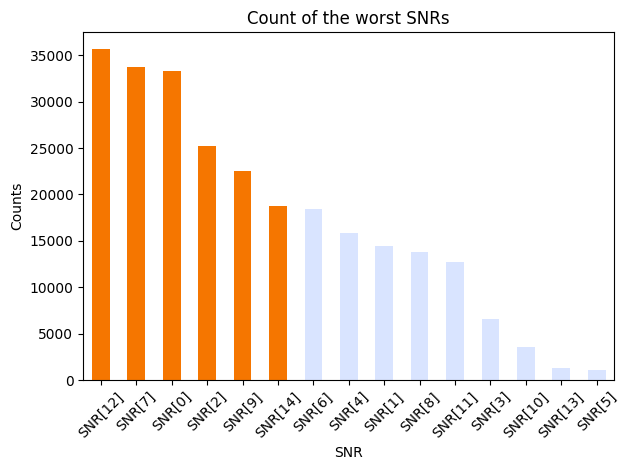

In [46]:
# STRATEGY 1: the area is the signal and RMS is the white noise
df_features = df.drop(columns=['x', 'y', 'Id'])

rms_start_column = 'rms[0]'
area_start_column = 'area[0]'

area_start_index = df_features.columns.get_loc(area_start_column)
area_columns_name = [df_features.iloc[:, area_start_index+5*i].name for i in range(0, 18)]

rms_start_index = df_features.columns.get_loc(rms_start_column)
rms_columns_name = [df_features.iloc[:, rms_start_index+5*i].name for i in range(0, 18)]


S = df_features[area_columns_name]
N = df_features[rms_columns_name]

snr_name_columns = [f'SNR[{i}]' for i in range(18)]
# Selecting the absolute value of S: what does matter is the amplitude of the signal only
SNR = pd.DataFrame(10*np.log10(np.abs(S.to_numpy())/N.to_numpy()), columns=snr_name_columns)

worst_SNR_list = []
# Taking a small fraction of SNR Dataframe
SNR_frac = SNR.sample(frac=1/12, random_state=331438)
print('Selecting the 6 worst SNR ...')
for i in tqdm(range((len(SNR_frac)))):
    worst_SNR_list.append(SNR_frac.iloc[i,:].sort_values(ascending=False).iloc[12:].index.to_list())

# Once created, merge all the lists in a single list    
worst_SNR_list = [worst_SNR for SNR_list in worst_SNR_list for worst_SNR in SNR_list]
# Converting the list in a Serie to use value_counts()
worst_SNR_counts = pd.Series(worst_SNR_list).value_counts()

# PLOT
colors = ['#f57600' if i < 6 else '#d9e4ff' for i in range(len(worst_SNR_counts))]
worst_SNR_counts.plot(kind='bar', color=colors)
plt.xlabel('SNR')
plt.ylabel('Counts')
plt.title('Count of the worst SNRs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Selecting the 6 lowest peaks ...


100%|██████████| 42833/42833 [00:12<00:00, 3438.71it/s]


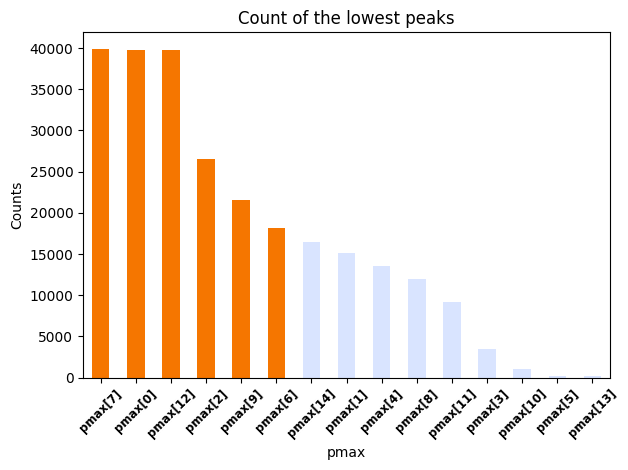

In [55]:
# STRATEGY 2: higher peak is the signal

pmax_start_column = 'pmax[0]'
pmax_start_index = df_features.columns.get_loc(pmax_start_column)
pmax_columns_name = [df_features.iloc[:, pmax_start_index+5*i].name for i in range(0, 18)]

df_pmax = pd.DataFrame(df_features[pmax_columns_name], columns=pmax_columns_name)

df_pmax_frac = df_pmax.sample(frac=1/12, random_state=331438)
lowest_pmax_list = []
print('Selecting the 6 lowest peaks ...')
for i in tqdm(range((len(df_pmax_frac)))):
    lowest_pmax_list.append(df_pmax_frac.iloc[i,:].sort_values(ascending=False).iloc[12:].index.to_list())
    
# Once created, merge all the lists in a single list    
lowest_pmax_list = [lowest_pmax for pmax_list in lowest_pmax_list for lowest_pmax in pmax_list]
# Converting the list in a Serie to use value_counts()
lowest_pmax_counts = pd.Series(lowest_pmax_list).value_counts()

# PLOT
colors = ['#f57600' if i < 6 else '#d9e4ff' for i in range(len(lowest_pmax_counts))]
lowest_pmax_counts.plot(kind='bar', color=colors)
plt.xlabel('pmax')
plt.ylabel('Counts')
plt.title('Count of the lowest peaks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
    

The two methods are compatible except for one column (column type[6] and column type[14]): it is possible to understand this result thanks to the SNR analysis. In fact, the two columns have more or less SNR similar value.

This suggest that 1 pad of the 12 has not negligible noise.

One simple approach is to study the regression using only 11 pads.

In [64]:
list_columns_noise = [lowest_pmax_counts.index.to_list(), worst_SNR_counts.index.to_list()]
list_columns_noise = [column for column_noise in list_columns_noise for column in column_noise, 'pmax[14]', 'SNR']
list_columns_noise

['pmax[7]',
 'pmax[0]',
 'pmax[12]',
 'pmax[2]',
 'pmax[9]',
 'pmax[6]',
 'pmax[14]',
 'pmax[1]',
 'pmax[4]',
 'pmax[8]',
 'pmax[11]',
 'pmax[3]',
 'pmax[10]',
 'pmax[5]',
 'pmax[13]',
 'SNR[12]',
 'SNR[7]',
 'SNR[0]',
 'SNR[2]',
 'SNR[9]',
 'SNR[14]',
 'SNR[6]',
 'SNR[4]',
 'SNR[1]',
 'SNR[8]',
 'SNR[11]',
 'SNR[3]',
 'SNR[10]',
 'SNR[13]',
 'SNR[5]']

### Regressor

In [5]:
train_col = [col for col in df.columns if col not in ['x', 'y']]

# NaN values on Id come from the df_dev DataFrames

X = df.loc[df['Id'].isna(), train_col].drop(columns='Id').values    
y = df.loc[df['Id'].isna(), ['x','y']].values



#X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, shuffle=True, random_state=331438)

In [6]:
X = df[train_col].drop(columns='Id').values
y = df[['x','y']].values
feature_names = df.drop(columns=['x', 'y']).columns

X_train_valid = X[df['Id'].isna()]
y_train_valid = y[df['Id'].isna()]
X_test = X[~df['Id'].isna()]
y_test = y[~df['Id'].isna()]

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, shuffle=True, random_state=331438)

In [7]:
y_train.shape

(289125, 2)

We can now train a random forest with the default parameters to establish an initial baseline.

In [8]:

reg = MultiOutputRegressor(RandomForestRegressor(10, random_state=331438))
reg.fit(X_train , y_train)
euclidean_distances(y_valid, reg.predict(X_valid))